# Method 9 - Best Ideas DGTW Select

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calc HFU Asset Weight

valid_data['weight'] = valid_data.groupby(['datadate', 'fsym_id'])['pos_val'].transform('sum') / \
                                          valid_data.groupby('datadate')['pos_val'].transform('sum')

# Calculate HFU Relative Weight

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')[
    'institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_beg_pos = p.beg_port.iloc[1:].resample('M', level=0).apply(epd.take_first)
dgtw = crsp.get_dgtw_returns(list(set(best_ideas['fsym_id'].dropna())),
                    best_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
dgtw_pivot = pd.pivot_table(dgtw, index='datadate', columns='fsym_id', values='total_return')
dgtw_cont = monthly_beg_pos.mul(dgtw_pivot, axis=1, level=0).sum(axis=1)

monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - dgtw_cont).dropna()
monthly_return.name = 'port_return'

## Plot Performance

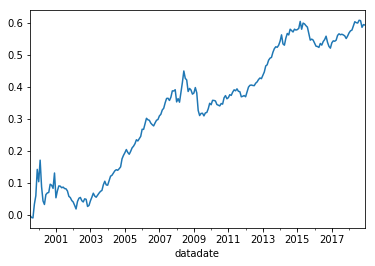

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.141880
2000-12-31   -0.009940
2001-12-31   -0.076088
2002-12-31   -0.014765
2003-12-31    0.062337
2004-12-31    0.084572
2005-12-31    0.050130
2006-12-31    0.042377
2007-12-31    0.071742
2008-12-31   -0.009906
2009-12-31   -0.020660
2010-12-31    0.010339
2011-12-31    0.007337
2012-12-31    0.038550
2013-12-31    0.073381
2014-12-31    0.031006
2015-12-31   -0.019892
2016-12-31   -0.016309
2017-12-31    0.024992
2018-12-31    0.021986
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     13.28
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.51e-10
Time:                        20:45:38   Log-Likelihood:                 691.90
No. Observations:                 234   AIC:                            -1374.
Df Residuals:                     229   BIC:                            -1357.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.242      0.216      -0.001       0.003
mktrf          0.0265      0.024      1.119      0.264      -0.020       0.073
me             0.1767      0.028      6.404      0.000       0.122       0.231
ia            -0.1386      0.042     -3.305      0.001      -0.221      -0.056
roe            0.1366      0.036      3.805      0.000       0.066       0.207
==============================================================================
Omnibus:                       62.968   Durbin-Watson:                   2.215
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              921.909
Skew:                          -0.538   Prob(JB):                    6.46e-201
Kurtosis:                      12.664   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     5.442
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000334
Time:                        20:45:38   Log-Likelihood:                 691.90
No. Observations:                 234   AIC:                            -1374.
Df Residuals:                     229   BIC:                            -1357.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.234      0.217      -0.001       0.003
mktrf          0.0265      0.034      0.779      0.436      -0.040       0.093
me             0.1767      0.059      3.004      0.003       0.061       0.292
ia            -0.1386      0.110     -1.259      0.208      -0.354       0.077
roe            0.1366      0.064      2.121      0.034       0.010       0.263
==============================================================================
Omnibus:                       62.968   Durbin-Watson:                   2.215
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              921.909
Skew:                          -0.538   Prob(JB):                    6.46e-201
Kurtosis:                      12.664   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     4.401
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00191
Time:                        20:45:38   Log-Likelihood:                 691.90
No. Observations:                 234   AIC:                            -1374.
Df Residuals:                     229   BIC:                            -1357.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.103      0.270      -0.001       0.003
mktrf          0.0265      0.026      1.006      0.314      -0.025       0.078
me             0.1767      0.064      2.766      0.006       0.051       0.302
ia            -0.1386      0.095     -1.465      0.143      -0.324       0.047
roe            0.1366      0.056      2.448      0.014       0.027       0.246
==============================================================================
Omnibus:                       62.968   Durbin-Watson:                   2.215
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              921.909
Skew:                          -0.538   Prob(JB):                    6.46e-201
Kurtosis:                      12.664   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     9.049
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.30e-08
Time:                        20:45:38   Log-Likelihood:                 688.66
No. Observations:                 234   AIC:                            -1365.
Df Residuals:                     228   BIC:                            -1345.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      1.911      0.057   -5.32e-05       0.003
mktrf          0.0013      0.024      0.053      0.958      -0.046       0.049
smb            0.1315      0.032      4.128      0.000       0.069       0.194
hml           -0.1435      0.038     -3.819      0.000      -0.217      -0.069
rmw            0.0095      0.042      0.224      0.823      -0.074       0.093
cma            0.0744      0.054      1.378      0.170      -0.032       0.181
==============================================================================
Omnibus:                       69.026   Durbin-Watson:                   2.307
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1007.700
Skew:                          -0.665   Prob(JB):                    1.52e-219
Kurtosis:                      13.079   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     2.838
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0166
Time:                        20:45:38   Log-Likelihood:                 688.66
No. Observations:                 234   AIC:                            -1365.
Df Residuals:                     228   BIC:                            -1345.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      2.163      0.031       0.000       0.003
mktrf          0.0013      0.024      0.053      0.958      -0.046       0.048
smb            0.1315      0.051      2.584      0.010       0.032       0.231
hml           -0.1435      0.046     -3.099      0.002      -0.234      -0.053
rmw            0.0095      0.050      0.188      0.851      -0.089       0.108
cma            0.0744      0.126      0.591      0.555      -0.172       0.321
==============================================================================
Omnibus:                       69.026   Durbin-Watson:                   2.307
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1007.700
Skew:                          -0.665   Prob(JB):                    1.52e-219
Kurtosis:                      13.079   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     3.114
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00970
Time:                        20:45:38   Log-Likelihood:                 688.66
No. Observations:                 234   AIC:                            -1365.
Df Residuals:                     228   BIC:                            -1345.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      1.913      0.056   -4.19e-05       0.003
mktrf          0.0013      0.020      0.064      0.949      -0.038       0.040
smb            0.1315      0.044      2.958      0.003       0.044       0.219
hml           -0.1435      0.051     -2.835      0.005      -0.243      -0.044
rmw            0.0095      0.045      0.213      0.831      -0.078       0.097
cma            0.0744      0.129      0.578      0.563      -0.178       0.327
==============================================================================
Omnibus:                       69.026   Durbin-Watson:                   2.307
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1007.700
Skew:                          -0.665   Prob(JB):                    1.52e-219
Kurtosis:                      13.079   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     61.63
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.78e-35
Time:                        20:45:38   Log-Likelihood:                 752.98
No. Observations:                 234   AIC:                            -1496.
Df Residuals:                     229   BIC:                            -1479.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.238      0.217      -0.000       0.002
mktrf          0.0822      0.017      4.888      0.000       0.049       0.115
smb            0.0635      0.021      3.023      0.003       0.022       0.105
hml           -0.0417      0.021     -2.001      0.047      -0.083      -0.001
umd            0.1797      0.014     13.130      0.000       0.153       0.207
==============================================================================
Omnibus:                       47.399   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              279.307
Skew:                          -0.595   Prob(JB):                     2.23e-61
Kurtosis:                       8.218   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     17.33
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.94e-12
Time:                        20:45:38   Log-Likelihood:                 752.98
No. Observations:                 234   AIC:                            -1496.
Df Residuals:                     229   BIC:                            -1479.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.174      0.241      -0.001       0.002
mktrf          0.0822      0.027      3.089      0.002       0.030       0.134
smb            0.0635      0.032      1.963      0.050       0.000       0.127
hml           -0.0417      0.039     -1.061      0.289      -0.119       0.035
umd            0.1797      0.029      6.165      0.000       0.123       0.237
==============================================================================
Omnibus:                       47.399   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              279.307
Skew:                          -0.595   Prob(JB):                     2.23e-61
Kurtosis:                       8.218   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     16.54
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.41e-12
Time:                        20:45:38   Log-Likelihood:                 752.98
No. Observations:                 234   AIC:                            -1496.
Df Residuals:                     229   BIC:                            -1479.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.049      0.294      -0.001       0.002
mktrf          0.0822      0.023      3.523      0.000       0.036       0.128
smb            0.0635      0.024      2.620      0.009       0.016       0.111
hml           -0.0417      0.033     -1.270      0.204      -0.106       0.023
umd            0.1797      0.032      5.691      0.000       0.118       0.242
==============================================================================
Omnibus:                       47.399   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              279.307
Skew:                          -0.595   Prob(JB):                     2.23e-61
Kurtosis:                       8.218   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     10.01
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.52e-07
Time:                        20:45:38   Log-Likelihood:                 327.22
No. Observations:                 120   AIC:                            -644.4
Df Residuals:                     115   BIC:                            -630.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.002      0.202      0.841      -0.003       0.003
mktrf          0.0742      0.042      1.780      0.078      -0.008       0.157
me             0.2312      0.041      5.616      0.000       0.150       0.313
ia            -0.1495      0.064     -2.320      0.022      -0.277      -0.022
roe            0.2292      0.057      4.017      0.000       0.116       0.342
==============================================================================
Omnibus:                       25.038   Durbin-Watson:                   2.206
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.869
Skew:                          -0.374   Prob(JB):                     2.11e-32
Kurtosis:                       8.349   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     7.517
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.05e-05
Time:                        20:45:38   Log-Likelihood:                 327.22
No. Observations:                 120   AIC:                            -644.4
Df Residuals:                     115   BIC:                            -630.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.002      0.202      0.840      -0.003       0.003
mktrf          0.0742      0.060      1.240      0.215      -0.043       0.191
me             0.2312      0.071      3.261      0.001       0.092       0.370
ia            -0.1495      0.138     -1.084      0.279      -0.420       0.121
roe            0.2292      0.078      2.924      0.003       0.076       0.383
==============================================================================
Omnibus:                       25.038   Durbin-Watson:                   2.206
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.869
Skew:                          -0.374   Prob(JB):                     2.11e-32
Kurtosis:                       8.349   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     7.105
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.79e-05
Time:                        20:45:38   Log-Likelihood:                 327.22
No. Observations:                 120   AIC:                            -644.4
Df Residuals:                     115   BIC:                            -630.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.002      0.182      0.855      -0.003       0.004
mktrf          0.0742      0.044      1.676      0.094      -0.013       0.161
me             0.2312      0.078      2.975      0.003       0.079       0.384
ia            -0.1495      0.123     -1.211      0.226      -0.392       0.093
roe            0.2292      0.057      4.046      0.000       0.118       0.340
==============================================================================
Omnibus:                       25.038   Durbin-Watson:                   2.206
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.869
Skew:                          -0.374   Prob(JB):                     2.11e-32
Kurtosis:                       8.349   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     4.917
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000411
Time:                        20:45:38   Log-Likelihood:                 321.02
No. Observations:                 120   AIC:                            -630.0
Df Residuals:                     114   BIC:                            -613.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.002      0.852      0.396      -0.002       0.005
mktrf          0.0117      0.046      0.252      0.801      -0.080       0.104
smb            0.1665      0.053      3.163      0.002       0.062       0.271
hml           -0.1696      0.065     -2.628      0.010      -0.297      -0.042
rmw            0.0506      0.076      0.665      0.507      -0.100       0.201
cma            0.1066      0.083      1.279      0.204      -0.059       0.272
==============================================================================
Omnibus:                       28.684   Durbin-Watson:                   2.352
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              159.206
Skew:                          -0.550   Prob(JB):                     2.68e-35
Kurtosis:                       8.535   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     2.386
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0425
Time:                        20:45:38   Log-Likelihood:                 321.02
No. Observations:                 120   AIC:                            -630.0
Df Residuals:                     114   BIC:                            -613.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      0.996      0.319      -0.001       0.004
mktrf          0.0117      0.051      0.231      0.817      -0.088       0.111
smb            0.1665      0.074      2.258      0.024       0.022       0.311
hml           -0.1696      0.071     -2.396      0.017      -0.308      -0.031
rmw            0.0506      0.081      0.627      0.531      -0.108       0.209
cma            0.1066      0.155      0.686      0.493      -0.198       0.411
==============================================================================
Omnibus:                       28.684   Durbin-Watson:                   2.352
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              159.206
Skew:                          -0.550   Prob(JB):                     2.68e-35
Kurtosis:                       8.535   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     2.803
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0200
Time:                        20:45:38   Log-Likelihood:                 321.02
No. Observations:                 120   AIC:                            -630.0
Df Residuals:                     114   BIC:                            -613.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.002      0.878      0.380      -0.002       0.005
mktrf          0.0117      0.047      0.252      0.801      -0.079       0.103
smb            0.1665      0.063      2.644      0.008       0.043       0.290
hml           -0.1696      0.077     -2.208      0.027      -0.320      -0.019
rmw            0.0506      0.074      0.681      0.496      -0.095       0.196
cma            0.1066      0.156      0.682      0.495      -0.200       0.413
==============================================================================
Omnibus:                       28.684   Durbin-Watson:                   2.352
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              159.206
Skew:                          -0.550   Prob(JB):                     2.68e-35
Kurtosis:                       8.535   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     44.27
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.90e-22
Time:                        20:45:38   Log-Likelihood:                 365.23
No. Observations:                 120   AIC:                            -720.5
Df Residuals:                     115   BIC:                            -706.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.169      0.245      -0.001       0.003
mktrf          0.1260      0.027      4.709      0.000       0.073       0.179
smb            0.0482      0.030      1.584      0.116      -0.012       0.109
hml           -0.0381      0.031     -1.248      0.214      -0.099       0.022
umd            0.2148      0.019     11.418      0.000       0.178       0.252
==============================================================================
Omnibus:                       28.316   Durbin-Watson:                   2.108
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.678
Skew:                          -0.829   Prob(JB):                     4.99e-18
Kurtosis:                       6.631   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     26.44
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.48e-15
Time:                        20:45:38   Log-Likelihood:                 365.23
No. Observations:                 120   AIC:                            -720.5
Df Residuals:                     115   BIC:                            -706.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.115      0.265      -0.001       0.004
mktrf          0.1260      0.038      3.339      0.001       0.052       0.200
smb            0.0482      0.037      1.288      0.198      -0.025       0.122
hml           -0.0381      0.045     -0.838      0.402      -0.127       0.051
umd            0.2148      0.029      7.298      0.000       0.157       0.272
==============================================================================
Omnibus:                       28.316   Durbin-Watson:                   2.108
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.678
Skew:                          -0.829   Prob(JB):                     4.99e-18
Kurtosis:                       6.631   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     30.75
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.10e-17
Time:                        20:45:38   Log-Likelihood:                 365.23
No. Observations:                 120   AIC:                            -720.5
Df Residuals:                     115   BIC:                            -706.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.042      0.298      -0.001       0.004
mktrf          0.1260      0.025      4.941      0.000       0.076       0.176
smb            0.0482      0.025      1.945      0.052      -0.000       0.097
hml           -0.0381      0.040     -0.964      0.335      -0.116       0.039
umd            0.2148      0.027      8.013      0.000       0.162       0.267
==============================================================================
Omnibus:                       28.316   Durbin-Watson:                   2.108
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.678
Skew:                          -0.829   Prob(JB):                     4.99e-18
Kurtosis:                       6.631   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     5.707
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000329
Time:                        20:45:38   Log-Likelihood:                 420.62
No. Observations:                 114   AIC:                            -831.2
Df Residuals:                     109   BIC:                            -817.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      2.834      0.005       0.001       0.003
mktrf          0.0121      0.018      0.667      0.506      -0.024       0.048
me             0.0329      0.028      1.174      0.243      -0.023       0.089
ia            -0.1464      0.039     -3.760      0.000      -0.224      -0.069
roe           -0.0616      0.034     -1.800      0.075      -0.129       0.006
==============================================================================
Omnibus:                        3.054   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.217   Jarque-Bera (JB):                2.465
Skew:                          -0.323   Prob(JB):                        0.292
Kurtosis:                       3.319   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     4.751
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00143
Time:                        20:45:38   Log-Likelihood:                 420.62
No. Observations:                 114   AIC:                            -831.2
Df Residuals:                     109   BIC:                            -817.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      2.801      0.005       0.001       0.003
mktrf          0.0121      0.017      0.720      0.471      -0.021       0.045
me             0.0329      0.040      0.818      0.413      -0.046       0.112
ia            -0.1464      0.050     -2.919      0.004      -0.245      -0.048
roe           -0.0616      0.044     -1.412      0.158      -0.147       0.024
==============================================================================
Omnibus:                        3.054   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.217   Jarque-Bera (JB):                2.465
Skew:                          -0.323   Prob(JB):                        0.292
Kurtosis:                       3.319   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     4.972
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00101
Time:                        20:45:38   Log-Likelihood:                 420.62
No. Observations:                 114   AIC:                            -831.2
Df Residuals:                     109   BIC:                            -817.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      2.307      0.021       0.000       0.003
mktrf          0.0121      0.016      0.780      0.435      -0.018       0.043
me             0.0329      0.040      0.829      0.407      -0.045       0.111
ia            -0.1464      0.049     -3.013      0.003      -0.242      -0.051
roe           -0.0616      0.039     -1.582      0.114      -0.138       0.015
==============================================================================
Omnibus:                        3.054   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.217   Jarque-Bera (JB):                2.465
Skew:                          -0.323   Prob(JB):                        0.292
Kurtosis:                       3.319   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     7.002
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.06e-05
Time:                        20:45:38   Log-Likelihood:                 425.78
No. Observations:                 114   AIC:                            -839.6
Df Residuals:                     108   BIC:                            -823.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      2.590      0.011       0.000       0.003
mktrf          0.0208      0.017      1.252      0.213      -0.012       0.054
smb            0.0446      0.027      1.649      0.102      -0.009       0.098
hml           -0.1065      0.034     -3.090      0.003      -0.175      -0.038
rmw           -0.0903      0.042     -2.141      0.035      -0.174      -0.007
cma           -0.0404      0.054     -0.755      0.452      -0.147       0.066
==============================================================================
Omnibus:                        3.851   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.146   Jarque-Bera (JB):                3.229
Skew:                          -0.364   Prob(JB):                        0.199
Kurtosis:                       3.389   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     5.469
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000159
Time:                        20:45:38   Log-Likelihood:                 425.78
No. Observations:                 114   AIC:                            -839.6
Df Residuals:                     108   BIC:                            -823.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      2.693      0.007       0.000       0.003
mktrf          0.0208      0.019      1.120      0.263      -0.016       0.057
smb            0.0446      0.029      1.523      0.128      -0.013       0.102
hml           -0.1065      0.034     -3.175      0.001      -0.172      -0.041
rmw           -0.0903      0.037     -2.462      0.014      -0.162      -0.018
cma           -0.0404      0.058     -0.702      0.483      -0.153       0.072
==============================================================================
Omnibus:                        3.851   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.146   Jarque-Bera (JB):                3.229
Skew:                          -0.364   Prob(JB):                        0.199
Kurtosis:                       3.389   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     5.567
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000133
Time:                        20:45:38   Log-Likelihood:                 425.78
No. Observations:                 114   AIC:                            -839.6
Df Residuals:                     108   BIC:                            -823.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      2.325      0.020       0.000       0.003
mktrf          0.0208      0.019      1.119      0.263      -0.016       0.057
smb            0.0446      0.029      1.556      0.120      -0.012       0.101
hml           -0.1065      0.033     -3.220      0.001      -0.171      -0.042
rmw           -0.0903      0.042     -2.172      0.030      -0.172      -0.009
cma           -0.0404      0.053     -0.762      0.446      -0.144       0.063
==============================================================================
Omnibus:                        3.851   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.146   Jarque-Bera (JB):                3.229
Skew:                          -0.364   Prob(JB):                        0.199
Kurtosis:                       3.389   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     9.347
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.56e-06
Time:                        20:45:38   Log-Likelihood:                 426.59
No. Observations:                 114   AIC:                            -843.2
Df Residuals:                     109   BIC:                            -829.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.847      0.067   -7.85e-05       0.002
mktrf          0.0361      0.016      2.212      0.029       0.004       0.069
smb            0.0603      0.025      2.364      0.020       0.010       0.111
hml           -0.0822      0.026     -3.132      0.002      -0.134      -0.030
umd            0.0529      0.020      2.672      0.009       0.014       0.092
==============================================================================
Omnibus:                        2.462   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.292   Jarque-Bera (JB):                2.414
Skew:                          -0.348   Prob(JB):                        0.299
Kurtosis:                       2.848   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     15.53
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.38e-10
Time:                        20:45:38   Log-Likelihood:                 426.59
No. Observations:                 114   AIC:                            -843.2
Df Residuals:                     109   BIC:                            -829.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.870      0.061   -5.17e-05       0.002
mktrf          0.0361      0.015      2.467      0.014       0.007       0.065
smb            0.0603      0.030      2.013      0.044       0.002       0.119
hml           -0.0822      0.029     -2.800      0.005      -0.140      -0.025
umd            0.0529      0.018      2.935      0.003       0.018       0.088
==============================================================================
Omnibus:                        2.462   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.292   Jarque-Bera (JB):                2.414
Skew:                          -0.348   Prob(JB):                        0.299
Kurtosis:                       2.848   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     14.73
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.19e-09
Time:                        20:45:38   Log-Likelihood:                 426.59
No. Observations:                 114   AIC:                            -843.2
Df Residuals:                     109   BIC:                            -829.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.685      0.092      -0.000       0.002
mktrf          0.0361      0.013      2.854      0.004       0.011       0.061
smb            0.0603      0.032      1.911      0.056      -0.002       0.122
hml           -0.0822      0.029     -2.809      0.005      -0.140      -0.025
umd            0.0529      0.019      2.831      0.005       0.016       0.090
==============================================================================
Omnibus:                        2.462   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.292   Jarque-Bera (JB):                2.414
Skew:                          -0.348   Prob(JB):                        0.299
Kurtosis:                       2.848   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""